In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('bmh')

## Άμεσο σχήμα του Euler

In [6]:
def gauss(x, a, b, c):
    """
    Συνάρτηση Gauss
    a: ύψος της κορυφής της καμπύλης
    b: θέση της κορυφής της καμπύλης
    c: τυπική απόκλιση
    """
    return a*np.exp(-((x-b)**2/(2*c**2)))

def plug_profile(x, L, a, b):
    return 1 * (np.abs(x-L/a) > b)

def solve_diffusion1D_FE(L, T, dx, dt, d, I, *args):
    """
    Επιλύει την μονοδιάστατη διάχυση με το άμεσο σχήμα Euler (Forward Euler, FE) 
    θεωρώντας ομογενείς, μηδενικές, συνοριακές συνθήκες.
    L: μήκος χωρίου στη διάσταση x
    Τ: τελική χρονική στιγμή
    dx: χωρικό βήμα
    dt: χρονικό βήμα
    d: συντελεστής διάχυσης
    I: συνάρτηση που επιστρέφει την αρχική συνθήκη (πχ gauss ή plug_profile).
    *args: μέσω της λέξης κλειδί *args δηλώνεται δυναμικός αριθμός επιπλέον ορισμάτων.
    """
    
    xs = np.arange(0, L + dx, dx) # πεδίο ορισμού - υπολογιστικό πλέγμα
    xi = np.arange(0, xs.size)

    nsteps = int(T/dt)
    
    
    fig, ax = plt.subplots(1,1,figsize=(3,2), dpi = 150)
    plot_freq = int(nsteps/4)
    
    u0 = I(xs, *args) # αρχική συνθήκη. Το πρώτο όρισμα της συνάρτησης (xs) είναι το πεδίο ορισμού και τα
    # υπό΄λοιπα ορίσματα (αδιευκρίνιστα εκ των προτέρων) εισάγονται μέσω της λέξης κλειδί *args.
    u = np.zeros_like(xs) # τρέχων χρονικό βήμα
    F = d*dt/(dx**2)
       
    for n in range(nsteps+1):
        for i  in xi[1:-1]: # η επανάληψη δεν περιλαμβάνει το πρώτο και τελευταίο σημείο του πεδίου ορισμού τα οποία καθορίζονται
            # από τις συνοριακές συνθήκες.

            u[i] = u0[i] + F*(u0[i-1] - 2*u0[i] + u0[i+1])

        if n%plot_freq == 0:
            ax.plot(xs, u, label = f't={n*dt}')
        
        # επιβολή συνοριακών συνθηκών
        u[0] = 0  
        u[-1] = 0
        u0 = u

    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

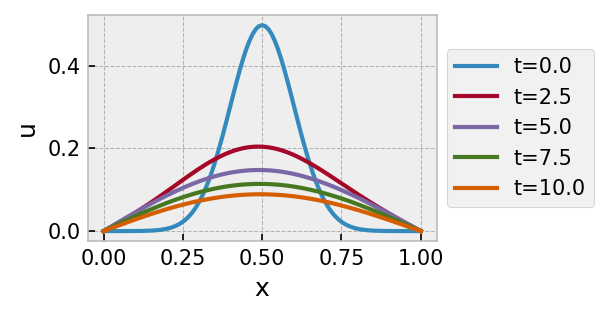

In [7]:
L = 1; T = 10; dx = 0.01; dt = 0.01; d = 0.005; a = 0.5; b = 0.5; c = 0.1
solve_diffusion1D_FE(L, T, dx, dt, d, gauss, a, b, c)

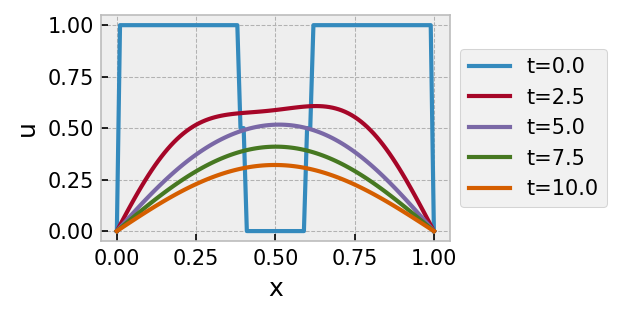

In [8]:
# Η αρχική συνθήκη ορίζεται μέσω της συνάρτησης plug_profile
L = 1; T = 10; dx = 0.01; dt = 0.01; d = 0.005; a = 2.0; b = 0.1
solve_diffusion1D_FE(L, T, dx, dt, d, plug_profile, L, a, b)

## Πεπλεγμένο σχήμα του Euler

In [11]:
import scipy.linalg # χρησιμοποιούμε το πακέτο scipy για την επίλυση γραμμικών συστημάτων

def solve_diffusion1D_BE(L, T, dx, dt, d, I, *args):
    """
    Επιλύει την μονοδιάστατη διάχυση με το πεπλεγμένο σχήμα Euler (Backward Euler, BE) 
    L: μήκος χωρίου στη διάσταση x
    Τ: τελική χρονική στιγμή
    dx: χωρικό βήμα
    dt: χρονικό βήμα
    d: συντελεστής διάχυσης
    I: συνάρτηση που επιστρέφει την αρχική συνθήκη (πχ gauss η plug_profile).
    """
    
    xs = np.arange(0, L + dx, dx) # πεδίο ορισμού
    xi = np.arange(0, xs.size)
    
    nsteps = int(T/dt)
    
    u0 = I(xs, *args)
    u = np.zeros_like(xs) # τρέχων χρονικό βήμα
    F = d*dt/(dx**2)
    
    # αρχικοποίηση πινάκων Α και b.
    A = np.zeros((xs.size, xs.size))
    b = np.zeros(xs.size)

    for i in xi[1:-1]:
        A[i,i-1] = -F
        A[i,i] = 1 + 2*F
        A[i,i+1] = -F

    A[0,0] = A[xi[-1],xi[-1]] = 1 # Α[0,0] = Α[Nx, Nx] = 0
    # Σύμφωνα με το αριθμητικό σχήμα, θα πρέπι να μηδενιστούν τα στοιχεία A[0,1] και Α[Nx, Nx-1]. Ωστόσο ΄΄εχει ήδη γίνει κατά
    # την αρχικοποίηση του πίνακα Α με μηδενικά.
    
    fig, ax = plt.subplots(1,1,figsize=(3,2), dpi = 100)
    plot_freq = int(nsteps/4)

    for n in range(nsteps+1):
        # Υπολογισμός του πίνακα b και επίλυση γραμμικού συστήματος
        for i in xi[1:-1]:
            b[i] = u0[i]

        b[0] = b[xi[-1]] = 0
        u = scipy.linalg.solve(A, b)
        u0 = u
    
        if n%plot_freq == 0:
            ax.plot(xs, u, label = f't={n*dt}')
        
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

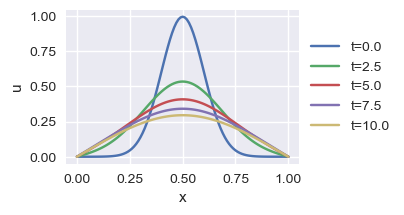

In [12]:
# Παράδειγμα επίλυσης μονοδιάστατης διάχυσης με το πεπλεγμένο σχ΄ήμα Euler. 
# Η αρχική συνθήκη ορίζεται μέσω της συνάρτησης gauss
L = 1; T = 10; dx = 0.01; dt = 0.01; d = 0.005; a = 1; b = 0.5; c = 0.1
solve_diffusion1D_BE(L, T, dx, dt, d, gauss, a, b, c)

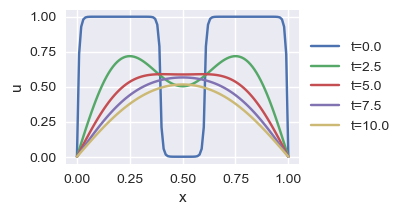

In [13]:
# Παράδειγμα επίλυσης μονοδιάστατης διάχυσης με άμεσο σχήμα Euler. 
# Η αρχική συνθήκη ορίζεται μέσω της συνάρτησης plug_profile
L = 1; T = 10; dx = 0.01; dt = 0.01; d = 0.005; a = 2.0; b = 0.1; 
solve_diffusion1D_BE(L, T, dx, dt, d, plug_profile, L, a, b)

## Το σχήμα των Crank-Nicolson

In [11]:
import scipy.linalg

def solve_diffusion1D_CR(L, T, dx, dt, d, I, *args):
    """
    Επιλύει την μονοδιάστατη διάχυση με το σχήμα Crank-Nicolson (CR)
    L: μήκος χωρίου στη διάσταση x
    Τ: τελική χρονική στιγμή
    dx: χωρικό βήμα
    dt: χρονικό βήμα
    d: συντελεστής διάχυσης
    I: συνάρτηση που επιστρέφει την αρχική συνθήκη (πχ gauss η plug_profile).
    """
    
    xs = np.arange(0, L+dx, dx) # πεδίο ορισμού
    xi = np.arange(0, xs.size)

    nsteps = int(T/dt)
    
    
    u0 = I(xs, *args)
    u = np.zeros_like(xs) # τρέχων χρονικό βήμα
    F = d*dt/(dx**2)
    
    # αρχικοποίηση πινάκων Α και b.
    A = np.zeros((xs.size, xs.size))
    b = np.zeros(xs.size)

    for i in xi[1:-1]:
        A[i,i-1] = -F/2
        A[i,i] = 1 + F
        A[i,i+1] = -F/2

    A[0,0] = A[xi[-1],xi[-1]] = 1
    
    fig, ax = plt.subplots(1,1,figsize=(3,2), dpi = 100)
    plot_freq = int(nsteps/4)

    for n in range(nsteps+1):
        for i in xi[1:-1]:
            b[i] = u0[i]
        b[0] = b[xi[-1]] = 0
        u = scipy.linalg.solve(A, b)

        u0 = u
    
        if n%plot_freq == 0:
            ax.plot(xs, u, label = f't={n*dt}')
        
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

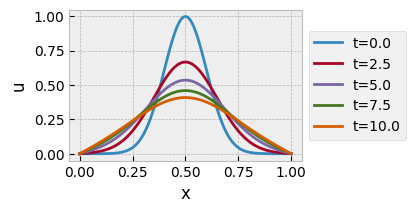

In [12]:
# Παράδειγμα επίλυσης μονοδιάστατης διάχυσης με το πεπλεγμένο σχ΄ήμα Euler. 
# Η αρχική συνθήκη ορίζεται μέσω της συνάρτησης gauss
L = 1; T = 10; dx = 0.01; dt = 0.01; d = 0.005; a = 1; b = 0.5; c = 0.1
solve_diffusion1D_CR(L, T, dx, dt, d, gauss, a, b, c)

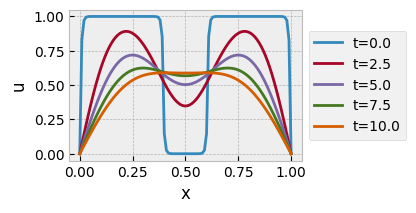

In [13]:
# Παράδειγμα επίλυσης μονοδιάστατης διάχυσης με άμεσο σχήμα Euler. 
# Η αρχική συνθήκη ορίζεται μέσω της συνάρτησης plug_profile
L = 1; T = 10; dx = 0.01; dt = 0.01; d = 0.005; a = 2.0; b = 0.1; 
solve_diffusion1D_CR(L, T, dx, dt, d, plug_profile, L, a, b)

## Ο κανόνας θ

In [14]:
import scipy.linalg

def tridiag(a, b, c, size):
    return np.diagflat([a]*(size-1), -1) + np.diagflat([b]*size, 0) + np.diagflat([c]*(size-1), 1)

def theta_rule_diffusion1D(L, T, dx, dt, d, theta, I, *args):
    
    xs = np.arange(0, L+dx, dx) # πεδίο ορισμού
    xi = np.arange(0, xs.size)

    nsteps = int(T/dt)
    
    u0 = I(xs, *args)
    u = np.zeros_like(xs) # τρέχων χρονικό βήμα
    F = d*dt/(dx**2)
    
    a = - F * theta
    b = 1 + 2 * F * theta
    c = - F * theta
    
    A = tridiag(a, b, c, xs.size)
    A[0,0] = A[xi[-1],xi[-1]] = 1
    b = np.zeros(xs.size)
    
    fig, ax = plt.subplots(1,1,figsize=(3,2), dpi = 100)
    plot_freq = int(nsteps/4)
    
    for n in range(nsteps+1):
        for i in xi[1:-1]:
            b[i] = u0[i]
        b[0] = b[xi[-1]] = 0
        u = scipy.linalg.solve(A, b)

        u0 = u
    
        if n%plot_freq == 0:
            ax.plot(xs, u, label = f't={n*dt}')
        
    ax.set_xlabel("x")
    ax.set_ylabel("u")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

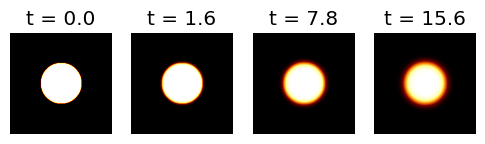

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def do_timestep(u0, u):
    # εμπρόσθιες διαφορές στο χρόνο, κεντρικές διαφορές στο χώρο
    u[1:-1, 1:-1] = u0[1:-1, 1:-1] + d * dt * (
          (u0[2:, 1:-1] - 2*u0[1:-1, 1:-1] + u0[:-2, 1:-1])/dx2
          + (u0[1:-1, 2:] - 2*u0[1:-1, 1:-1] + u0[1:-1, :-2])/dy2 )

    u0 = u.copy()
    return u0, u

 
Lx = Ly = 10.
dx = dy = 0.05
T = 10
dt = 0.1
d = 4.
nsteps = 101

nx, ny = int(Lx/dx), int(Ly/dy)

dx2, dy2 = dx*dx, dy*dy
dt = 0.5 * dx2 * dy2 / (d * (dx2 + dy2)) # το μέγιοστο dt ώστε το σχήμα να παραμένει ευσταθές (F=0.5)

u0 = np.zeros((nx, ny))
u = u0.copy()

# αρχική συνθήκη - κύκλος ακτίνας r και κέντρο (cx,cy)
r, cx, cy = 2, 5, 5
r2 = r**2
for i in range(nx):
    for j in range(ny):
        p2 = (i*dx-cx)**2 + (j*dy-cy)**2
        if p2 < r2:
            u0[i,j] = 1

# χρονικά σημεία

plot_timings = [0, 10, 50, 100]
fig, ax = plt.subplots(1, len(plot_timings), dpi = 100)

counter = 0
for j in range(nsteps):
    u0, u = do_timestep(u0, u)
    if j in plot_timings:
        ax[counter].imshow(u.copy(), cmap=plt.get_cmap('afmhot'), vmin=0,vmax=1)
        ax[counter].set_axis_off()
        ax[counter].set_title('t = {:.1f}'.format(j*dt*1000))
        counter += 1

plt.show()